In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import gzip
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# data path
path_csi =  'J:\\Data\\Wi-Fi_processed\\'
path_csi_hc = 'J:\\Data\\Wi-Fi_HC\\180_100\\'

# data info
df_info = pd.read_csv('data_subc_sig_v1.csv')
#df_info = df_info[df_info.id_person < 50]

person_uid = np.unique(df_info['id_person'])
dict_id = dict(zip(person_uid,np.arange(len(person_uid))))

# parameters
max_value = np.max(df_info['max'].values)
#no_classes = len(np.unique(df_info['id_person']))
no_classes = len(dict_id)
csi_time = int(np.max(df_info['len']))
csi_subc = 30
input_shape = (csi_time, csi_subc, 6)

# make data generator
def gen_csi(df_info,id_num,len_num):
    for file in set(df_info.id.values):
        # read sample data
        # load and uncompress.
        with gzip.open(path_csi+file+'.pickle.gz','rb') as f:
            data1 = pickle.load(f)
        abs_sub = np.mean(np.abs(data1),axis=(0,2,3))
        data1_norm = data1/abs_sub[np.newaxis,:,np.newaxis,np.newaxis]

        data1_abs = np.abs(data1_norm)
        data1_ph = np.angle(data1_norm)
        
        data1_diff = np.abs(data1)
        
        # differentiation
        #data1_diff = np.diff(data1_abs,axis=0)
        
        # zero pad
        pad_len = len_num - data1_diff.shape[0]
        data1_pad = np.pad(data1_diff,((0,pad_len),(0,0),(0,0),(0,0)),'constant',constant_values=0)

        # Label
        id_key = df_info[df_info.id==file]['id_person'].values[0].astype('int')
        data1_y = dict_id[id_key]

        x_input = data1_pad.reshape([-1,len_num,30,6]).astype('float32')
        y_input = tf.keras.utils.to_categorical(data1_y, no_classes).reshape([1,-1])
        
        yield(x_input / max_value,y_input)

C:\Users\herok\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
gen = gen_csi(df_info,no_classes,csi_time)

In [3]:
a,b = next(gen)

In [36]:
aa = a.flatten()
aa.shape

(2692800,)

In [9]:
np.argmax(b,1)

array([48], dtype=int64)

In [48]:
list_lab = []
list_data = []
for i in range(10):
    data,label = next(gen)
    data_f = data.squeeze()[:,:,0].flatten()
    label_val = np.argmax(label,1)
    list_lab.append(label_val)
    list_data.append(data_f)

In [50]:
df1_1 = df_info[(df_info.id_location==1) & (df_info.id_direction==1)]

In [53]:
df1_1.head()

,id,len,mean,std,id_person,id_location,id_direction,id_exp,id_paper,file,name,id_sign,median,max
256,S018_1_1_1,12451.0,18.545205,6.961028,18,1,1,1,IMG_0720,IMG_0720_2.png,정지원,18,17.218271,48.379566
257,S018_1_1_1,12451.0,18.545205,6.961028,18,1,1,1,IMG_0720,IMG_0720_3.png,정지원,18,17.218271,48.379566
258,S018_1_1_1,12451.0,18.545205,6.961028,18,1,1,1,IMG_0720,IMG_0720_4.png,정지원,18,17.218271,48.379566
259,S018_1_1_1,12451.0,18.545205,6.961028,18,1,1,1,IMG_0720,IMG_0720_6.png,정지원,18,17.218271,48.379566
260,S018_1_1_1,12451.0,18.545205,6.961028,18,1,1,1,IMG_0720,IMG_0720_7.png,정지원,18,17.218271,48.379566


In [59]:
# Make position dataframe
df1_1 = df_info[(df_info.id_location==1) & (df_info.id_direction==1)]
uid = np.unique(df1_1.id.values)

In [56]:
# Make Generator
gen = gen_csi(df1_1,no_classes,csi_time)

In [60]:
# gather antenna 0 data
list_lab = []
list_data = []
for i in range(len(uid)):
    data,label = next(gen)
    data_f = data.squeeze()[:,:,0].flatten()
    label_val = np.argmax(label,1)
    list_lab.append(label_val)
    list_data.append(data_f)
arr_lab = np.array(list_lab)
arr_data = np.array(list_data)

In [85]:
arr_data10 = arr_data[(arr_lab < 10).squeeze()]
arr_lab10 = arr_lab[(arr_lab<10).squeeze()]

In [86]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2,whiten=True)
pca.fit(arr_data10)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [88]:
#plotting PCA
from matplotlib.pyplot import cm
X_pca = pca.transform(arr_data10)

In [97]:
supercat = np.unique(arr_lab10)
target_ids = range(len(supercat))
color=cm.tab10(target_ids)

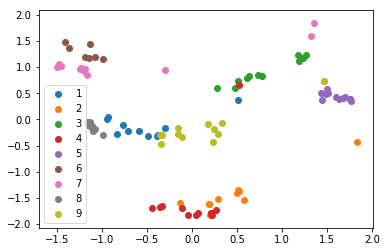

In [98]:
#color=cm.tab20(np.linspace(0,1,13))
from matplotlib import pyplot as plt
plt.figure()
for i, c, label in zip(target_ids, color, supercat):
    true_lab = (arr_lab10==label).squeeze()
    plt.scatter(X_pca[true_lab, 0], X_pca[true_lab, 1],c=c, label=label)
plt.legend()
plt.show()

In [94]:
np.unique(arr_lab10)

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [99]:
X_pca

(99, 2)